# Aggregation of water masks

This notebook shows how we can use EOScale in a practical context.
We will show how to chain EOScale filters to obtain a water mask, merge (and logic) water masks for 4 Sentinel-2 dates.

First we wil import every library we need for this notebook

In [6]:
import io
import zipfile
from functools import reduce
from pathlib import Path
from typing import List

import numpy as np
import rasterio
import requests
from rasterio.plot import show

from eoscale.core.eo_executors import n_images_to_m_images_filter
from eoscale.core.manager import EOContextManager

For this notebook, we will need to download some Sentinel-2 data (140MB). For each Sentinel-2 acquisition (4 dates), a water mask will be generated and all these masks will be aggregated.

In [7]:
DATA_DIR = "./"  # /!\ Change directory if you want
OUTPUT_DIR = "./"  # /!\ Change directory if you want

In [8]:
zip_file_url = "https://www.orfeo-toolbox.org/packages/WorkshopData/data_otb-guided-tour.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(DATA_DIR)

s2_20180621 = Path(DATA_DIR) / "data" / "xt_SENTINEL2B_20180621-111349-432_L2A_T30TWT_D_V1-8_RVBPIR.tif"
s2_20180701 = Path(DATA_DIR) / "data" / "xt_SENTINEL2B_20180701-111103-470_L2A_T30TWT_D_V1-8_RVBPIR.tif"
s2_20180706 = Path(DATA_DIR) / "data" / "xt_SENTINEL2A_20180706-110918-241_L2A_T30TWT_D_V1-8_RVBPIR.tif"
s2_20180711 = Path(DATA_DIR) / "data" / "xt_SENTINEL2B_20180711-111139-550_L2A_T30TWT_D_V1-8_RVBPIR.tif"

These data are not real Sentinel-2 data, we will only use RGB + Near Infrared data, centred on the city of Vannes in France for our tutorial.
Other Sentinel-2 data can be downloaded from [https://theia.cnes.fr](https://theia.cnes.fr/atdistrib/rocket/#/search?collection=SENTINEL2). 

Let's visualize this area of interest.

input data shape : (4, 2080, 2410) (bands, height, width)


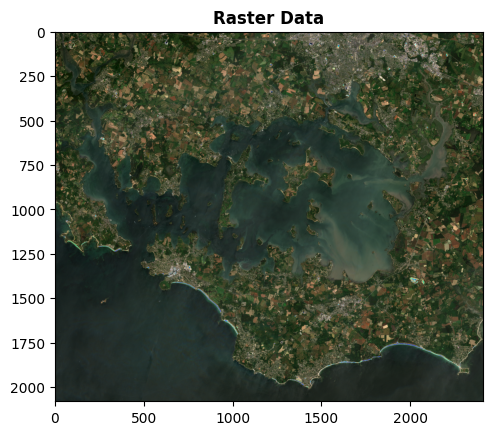

In [9]:
def show_raster(input_image:str):
    """
    Displays the RGB bands of a raster image with rescaling for visualization.

    Parameters
    ----------
    input_image : str
        Path to the input raster image.
    """
    with rasterio.open(input_image) as src:
        # get the RGB bands
        raster_data = src.read()
        print(f"input data shape : {raster_data.shape} (bands, height, width)")
        raster_data = raster_data[0:3,:,:]

        # create new range values for visualization purpose
        flat_array = raster_data.flatten()        
        lower_bound = np.quantile(flat_array, 0.001)
        upper_bound = np.quantile(flat_array, 0.999)
        mask = (raster_data >= lower_bound) & (raster_data <= upper_bound)
        filtered_array = np.where(mask, raster_data, 0)
        min_val = filtered_array.min()
        max_val = filtered_array.max()
        rescaled_array = (filtered_array - min_val) / (max_val - min_val) * 255

        show(rescaled_array.astype(np.uint8), title="Raster Data")
        
show_raster(s2_20180621)

It's now time to build the filter that will be responsible for creating an NDWI from one of the Sentinel-2 images we downloaded earlier.B

Compute NDWI...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 38.34it/s]


input data shape : (4, 2080, 2410) (bands, height, width)


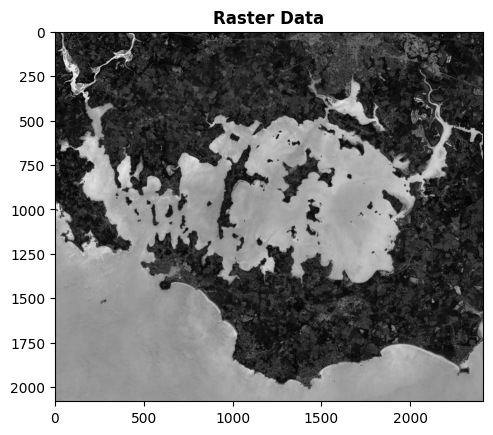

In [11]:
def ndwi_filter(input_buffers: list,
               input_profiles: list,
               params: dict) -> List[np.ndarray]:
    """
    Computes the NDWI for a list of input buffers.

    Parameters
    ----------
    input_buffers : list
        List of input buffers containing raster data.
    input_profiles : list
        List of profiles associated with the input buffers.
    params : dict
        Dictionary of parameters for the filter.

    Returns
    -------
    list of np.ndarray
        List of NDWI arrays.
    """
    eps = 0.001
    return [(input_buffer[1] - input_buffer[3]) / (input_buffer[1] + input_buffer[3] + eps) for input_buffer in input_buffers]


def copy_profile(input_profiles: list,
                 params: dict) -> dict:
    """
    Copies the profile of the input raster.

    Parameters
    ----------
    input_profiles : list
        List of input profiles.
    params : dict
        Dictionary of parameters.

    Returns
    -------
    dict
        Copied profile.
    """
    return input_profiles

    
def compute_ndwi(context: EOContextManager, input_files: List[str]):
    """
    Computes NDWI on a list of Sentinel-2 images.

    Parameters
    ----------
    context : EOContextManager
        Context manager for EO operations.
    input_files : List[str]
        List of paths to input raster files.

    Returns
    -------
    List[str]
        List of NDWI computed images.
    """
    return n_images_to_m_images_filter(inputs=[eoscale_manager.open_raster(input_file) for input_file in input_files],
                                       image_filter=ndwi_filter,
                                       generate_output_profiles=copy_profile,
                                       context_manager=context,
                                       filter_desc="Compute NDWI...")
s2_20180621_NDWI = Path(OUTPUT_DIR) / "s2_20180621_NDWI.tif"
with EOContextManager(nb_workers = 2, tile_mode = True) as eoscale_manager:
    ndwi_keys = compute_ndwi(eoscale_manager, [s2_20180621])
    eoscale_manager.write(ndwi_keys[0], str(s2_20180621_NDWI))
show_raster(s2_20180621_NDWI)

In [ ]:
Then we can create a new function to filter each NDWI product

Compute water mask...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.15it/s]


input data shape : (4, 2080, 2410) (bands, height, width)


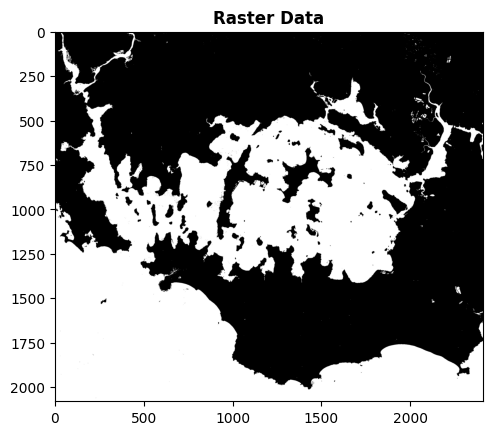

In [12]:
def water_mask_filter(input_buffers: list,
               input_profiles: list,
               params: dict) -> List[np.ndarray]:
    return [np.where(input_buffer > params["ndwi_threshold"], True, False).astype(bool) for input_buffer in input_buffers]

    
def water_mask(context: EOContextManager, input_files: str, ndwi_threshold: float):
    """
    Compute a water mask using threshold, 1 mean water 0 otherwise
    """
    return n_images_to_m_images_filter(inputs=input_files,
                                       image_filter=water_mask_filter,
                                       filter_parameters = {"ndwi_threshold":ndwi_threshold},
                                       generate_output_profiles=copy_profile,
                                       context_manager=context,
                                       filter_desc="Compute water mask...")
s2_20180621_water_mask = Path(OUTPUT_DIR) / "s2_20180621_water_mask.tif"
with EOContextManager(nb_workers = 2, tile_mode = True) as eoscale_manager:
    ndwi_keys = compute_ndwi(eoscale_manager, [s2_20180621])
    water_mask_keys = water_mask(eoscale_manager, ndwi_keys, 0)
    eoscale_manager.write(water_mask_keys[0], str(s2_20180621_water_mask))
show_raster(s2_20180621_water_mask)

Our output data is a binary data 1 mean water 0 otherwise. Now we are able to generate a water mask for each Sentinel-2 data and aggregate them thanks to a logical and.

Compute water mask aggregation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.11it/s]


input data shape : (4, 2080, 2410) (bands, height, width)


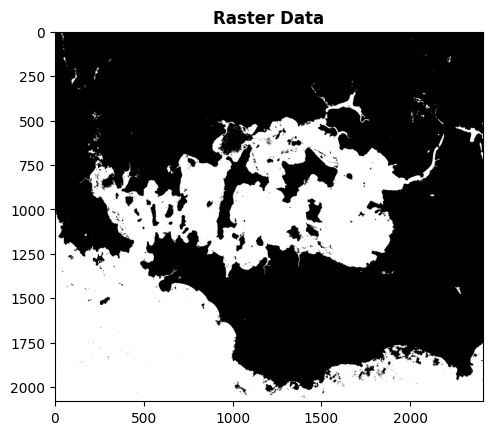

In [13]:
def water_mask_aggregation_profile(input_profiles: list,
                 params: dict) -> dict:
    return input_profiles[0]


def water_mask_aggregation_filter(input_buffers: list,
               input_profiles: list,
               params: dict) -> List[np.ndarray]:
    return [reduce(np.logical_and, input_buffers)]


def water_mask_aggregation(context: EOContextManager, input_files: str):
    """
    Compute a water mask using threshold, 1 mean water 0 otherwise
    """
    return n_images_to_m_images_filter(inputs=input_files,
                                       image_filter=water_mask_aggregation_filter,
                                       generate_output_profiles=water_mask_aggregation_profile,
                                       context_manager=context,
                                       filter_desc="Compute water mask aggregation...")
    
s2_20180621_water_mask = Path(OUTPUT_DIR) / "s2_20180621_water_mask.tif"
water_mask_agg = Path(OUTPUT_DIR) / "water_mask_agg.tif"
with EOContextManager(nb_workers = 2, tile_mode = True) as eoscale_manager:
    ndwi_keys = compute_ndwi(eoscale_manager, [s2_20180621, s2_20180701, s2_20180706, s2_20180711])
    water_mask_keys = water_mask(eoscale_manager, ndwi_keys, 0)
    water_mask_aggregation_keys = water_mask_aggregation(eoscale_manager, water_mask_keys)
    eoscale_manager.write(water_mask_aggregation_keys[0], str(water_mask_agg))
show_raster(water_mask_agg)